We will be doing an analysis of data about the number of people migrating to Canada from differnt parts of the world using Data visualisation and fit a line using Regression.

You can go through the dataset from the link below:
http://www.un.org/en/development/desa/population/migration/data/empirical2/migrationflows.shtml

The dataset contains annual data on the flows of international migrants as recorded by the countries of destination. The data presents both inflows and outflows according to the place of birth, citizenship or place of previous / next residence both for foreigners and nationals. We will focus on the Canadian Immigration data.

In [1]:
#importing the modules needed
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

In [2]:
#installing XLRD for pandas to read in Excel file
!conda install -c anaconda xlrd --yes

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be SUPERSEDED by a higher-priority channel:

    xlrd: 1.1.0-py35h45a0a2a_1 --> 1.1.0-py35_1 anaconda

xlrd-1.1.0-py3 100% |################################| Time: 0:00:00   6.43 MB/s


In [3]:
# downloading the data and reading it into pandas dataframe
df_can = pd.read_excel('https://ibm.box.com/shared/static/lw190pt9zpy5bd1ptyg2aw15awomz9pu.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skip_footer=2)

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [4]:
# view on the dataset
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


In [5]:
# print the dimensions of the dataframe
print(df_can.shape)

(195, 43)


In [6]:
#Cleaning of the dataset
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


In [7]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style


# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  2.1.0


In [8]:
# we will be using Waffle chart
# let's create a new dataframe for these three countries 
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]

# let's take a look at our dataframe
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


In [9]:
# to determin the proportin of each category
# compute the proportion of each category with respect to the total
total_values = sum(df_dsn['Total'])
category_proportions = [(float(value) / total_values) for value in df_dsn['Total']]

# print out proportions
for i, proportion in enumerate(category_proportions):
    print (df_dsn.index.values[i] + ': ' + str(proportion))

Denmark: 0.32255663965602777
Norway: 0.1924094592359848
Sweden: 0.48503390110798744


In [10]:
#the total number of tiles for fit
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print ('Total number of tiles is ', total_num_tiles)

Total number of tiles is  400


In [11]:
# distributing the proportion
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (df_dsn.index.values[i] + ': ' + str(tiles))

Denmark: 129
Norway: 77
Sweden: 194


In [12]:
# creating a matrix resembling the waffle chart
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

Waffle chart populated!


In [13]:
waffle_chart

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 

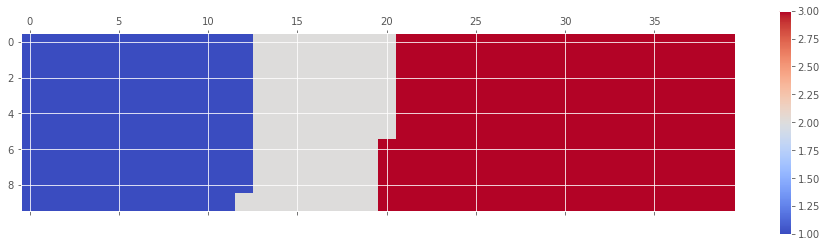

In [14]:
# visualizing the matrix above
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

([], <a list of 0 Text yticklabel objects>)

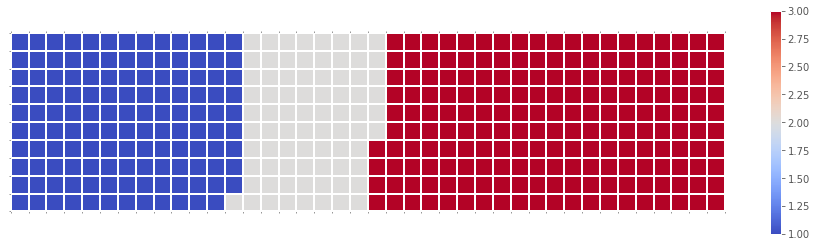

In [15]:
# arrangin the tiles for better look and understanding
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

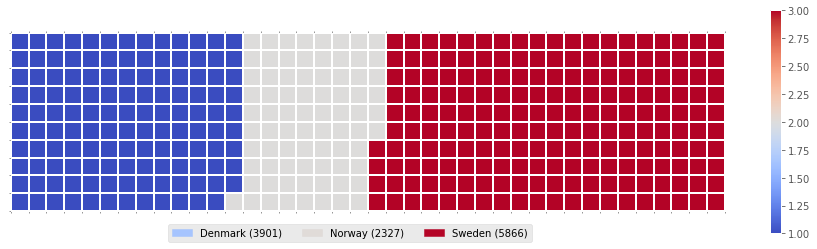

In [16]:
# creting a legend for the chart
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

# compute cumulative sum of individual categories to match color schemes between chart and legend
values_cumsum = np.cumsum(df_dsn['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(df_dsn.index.values):
    label_str = category + ' (' + str(df_dsn['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(df_dsn.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )

In [17]:
# creating a function for it
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

In [18]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


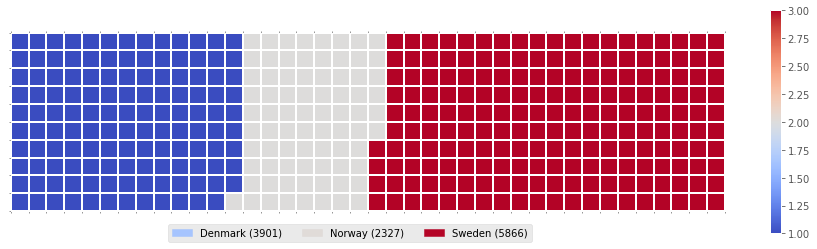

In [19]:
# calling the function to dispaly the  waffle chart
create_waffle_chart(categories, values, height, width, colormap)

In [20]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


In [22]:
# using Regression line of fit and Seaborn for data visualisation
# for that we 1st install seaborn
# install seaborn
!pip install seaborn

# import library
import seaborn as sns

print('Seaborn installed and imported!')

Requirement not upgraded as not directly required: seaborn in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from seaborn)
Requirement not upgraded as not directly required: scipy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from seaborn)
Requirement not upgraded as not directly required: matplotlib in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from seaborn)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from seaborn)
Requirement not upgraded as not directly required: six>=1.10 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from matplotlib->seaborn)
Requirement not upgraded as not directly required: python-dateutil>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from matplotlib->seaborn)
Requirement not upgraded as not directly

In [23]:
# create a dataframe that calculates total number of immigration that landed on Canada from 1980 to 2013 year wise.
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float,df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace = True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


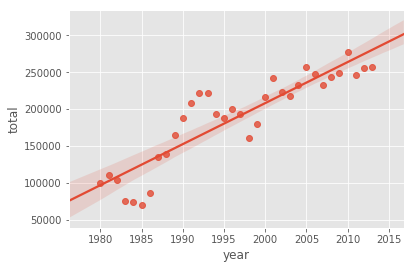

In [24]:
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot)

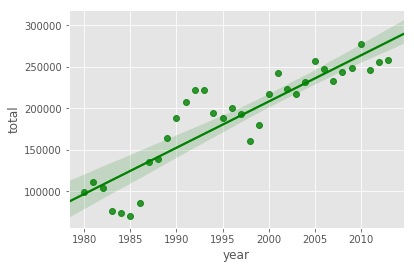

In [25]:
ax = sns.regplot(x='year', y='total', data=df_tot, color='green')

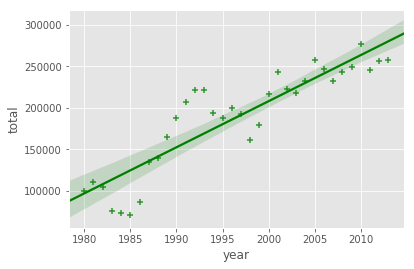

In [26]:
# using + sign
import seaborn as sns
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')

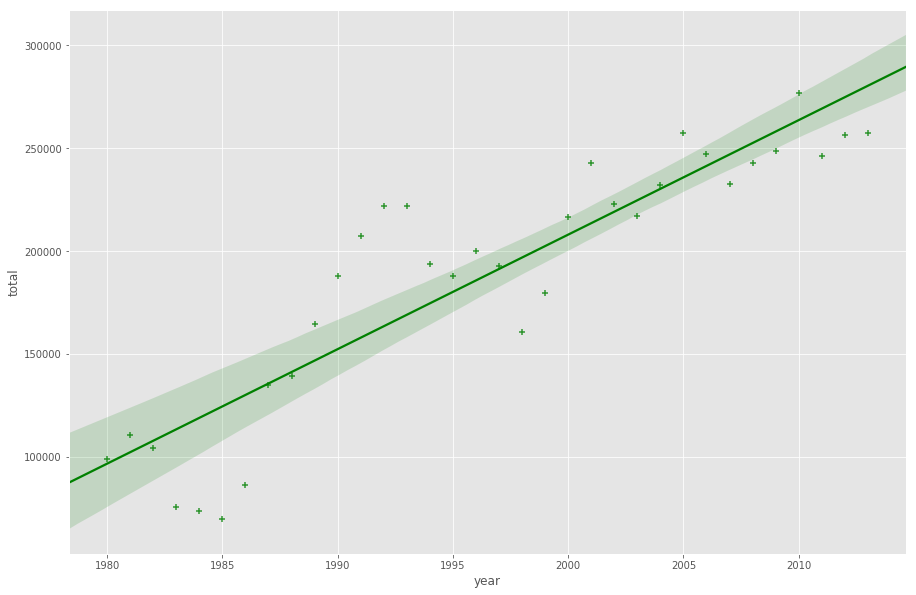

In [27]:
# increase the sixe of the chart
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+')

Text(0.5,1,'Total Immigration to Canada from 1980 - 2013')

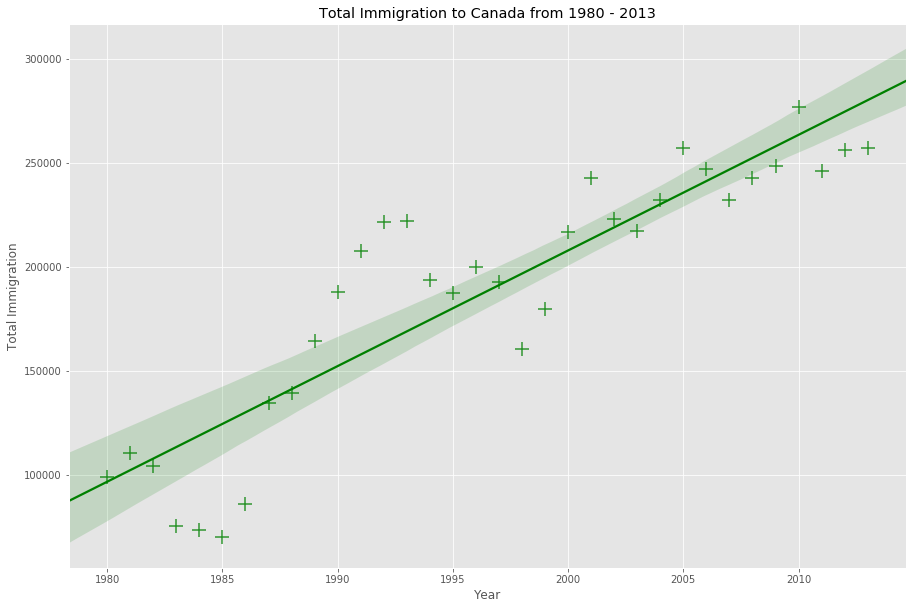

In [28]:
# increasing the size of the markers.
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})

ax.set(xlabel='Year', ylabel='Total Immigration') # add x- and y-labels
ax.set_title('Total Immigration to Canada from 1980 - 2013') # add title

Text(0.5,1,'Total Immigration to Canada from 1980 - 2013')

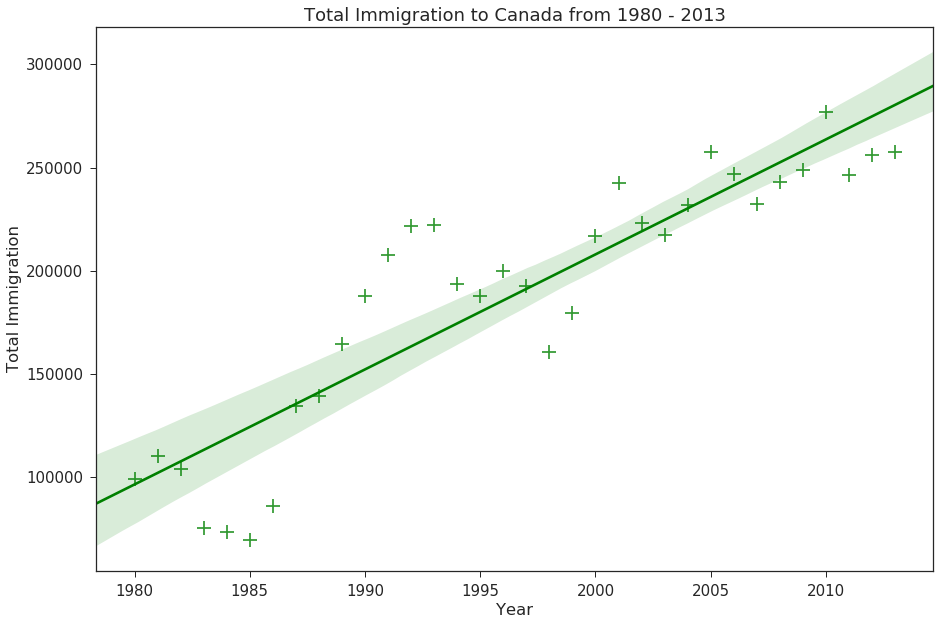

In [29]:
# to remove the background color too and make it more appealing
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks') # change background to white background

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Text(0.5,1,'Total Immigration to Canada from 1980 - 2013')

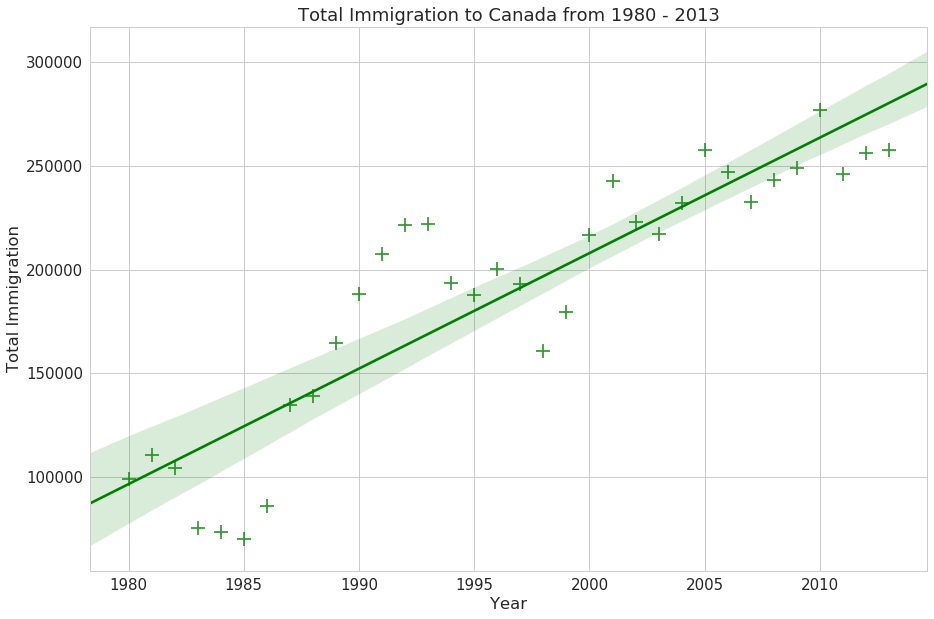

In [30]:
# if you want with grid lines.
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')

Text(0.5,1,'Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')

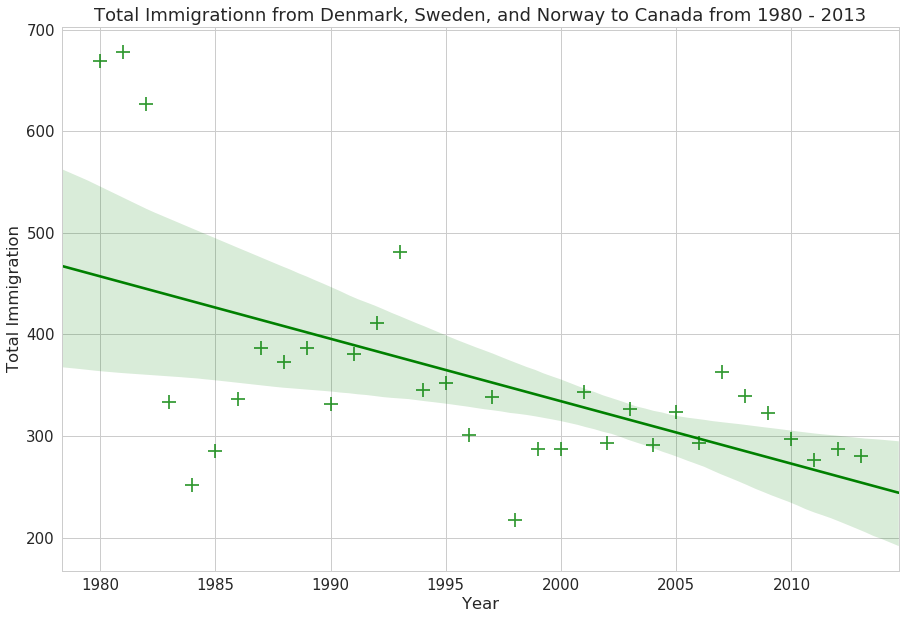

In [32]:
# here we will see the total immigration from Denmark, Swedan and Norway to Canada from 1980 to 2013.
### type your answer here

# create df_countries dataframe
df_countries = df_can.loc[['Denmark', 'Norway', 'Sweden'], years].transpose()

# create df_total by summing across three countries for each year
df_total = pd.DataFrame(df_countries.sum(axis=1))

#\\ # reset index in place
df_total.reset_index(inplace=True)

#\\ # rename columns
df_total.columns = ['year', 'total']

#\\ # change column year from string to int to create scatter plot
df_total['year'] = df_total['year'].astype(int)

#\\ # define figure size
plt.figure(figsize=(15, 10))

#\\ # define background style and font size
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

#\\ # generate plot and add title and axes labels
ax = sns.regplot(x='year', y='total', data=df_total, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')